# Assignment 3
## Libraries import

In [1]:
#np and pd
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#scikit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.naive_bayes import GaussianNB

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
import nltk
from nltk.corpus import stopwords

## Step 1: Data Loading and Data Cleaning


In [3]:
#read 2 required csv files
sentiment_analysis = pd.read_csv('sentiment_analysis.csv',encoding = 'utf-8')
ca_2019 = pd.read_csv('Canadian_elections_2019.csv',encoding = 'utf-8')

In [4]:
#firstly, check sentiment_analysis
sentiment_analysis.drop(columns = ['ID'],inplace= True)
sentiment_analysis.head()

,text,label
0,Josh Jenkins is looking forward to TAB Breeder...,1
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,"RT @PEPalerts: This September, @YESmag is taki...",1
3,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,RT @CedricFeschotte: Excited to announce: as o...,1


In [5]:
#check nan values
sentiment_analysis.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
#secondly check elections csv
ca_2019.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [7]:
#check nan values for dataset
ca_2019.isnull().sum()

sentiment             0
negative_reason    1126
text                  0
dtype: int64

Since the original text data has too much noisy, the cleaning requirement should achieved as below:
- All html tags and attributes (i.e., /<[^>]+>/) are removed.(check)
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.(check)
- All URLs are removed.(check)
- All characters in the text are in lowercase. (check)
- All stop words are removed. Be clear in what you consider as a stop word.(check)
- If a tweet is empty after pre-processing, it should be preserved as such.

#### lower case transformation
In order to conduct analysis on string values, one important step is to make the text in each tweet lowercase.

In [8]:
#make string values to lower case
sentiment_analysis['text'] = sentiment_analysis['text'].apply(lambda row: row.lower())
ca_2019['text'] = ca_2019['text'].apply(lambda row:row.lower())

#### html tags and attributes removal

In [9]:
import re, string
from string import punctuation

In [10]:
def clean_html(text):
    """
    This function is used to remove those html tags (such as <h1>Title</h1>).
    reference: https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    """
    clean_rule= re.compile('<.*?>')
    clean_text = re.sub(clean_rule, '', text)
    return clean_text

In [11]:
#apply function to the dataset
sentiment_analysis['clean_text'] = sentiment_analysis['text'].apply(lambda row: clean_html(row))
ca_2019['clean_text'] = ca_2019['text'].apply(lambda row: clean_html(row))

#### html character replacement

In [12]:
import html
import unicodedata

In [13]:
def replace_htmlcharac(text):
    """
    This function is used to replace html character codes (i.e., &...;) with an ASCII equivalent
    reference: https://www.geeksforgeeks.org/html-unescape-in-python/
    https://stackoverflow.com/questions/3194516/replace-special-characters-with-ascii-equivalent
    """
    text = html.unescape(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    return text

In [14]:
#apply function to the dataset
sentiment_analysis['clean_text'] = sentiment_analysis['clean_text'].apply(lambda row: replace_htmlcharac(row))
ca_2019['clean_text'] = ca_2019['clean_text'].apply(lambda row: replace_htmlcharac(row))

#### url remove

In [15]:
def remove_url(text):
    """
    This function is used to remove url portion of a text.
    reference: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
    """
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

In [16]:
#apply function to the dataset
sentiment_analysis['clean_text'] = sentiment_analysis['clean_text'].apply(lambda row: remove_url(str(row)))
ca_2019['clean_text'] = ca_2019['clean_text'].apply(lambda row: remove_url(str(row)))

#### punctuations and stop words removal

In [17]:
def remove_punc(text):
    """
    This function is used to remove those punctuation in the text while the punctuation list is from string.punctuation
    reference: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    """
    regex = re.compile('[%s]' % re.escape(punctuation))
    return regex.sub('', text)

def remove_stop(text):
    """
    This function is used to remove those stop words, and the stop words are from nltk.stipwords.
    """
    wordlist = text.split()
    word_temp = stopwords.words('english')
    word_temp = word_temp + [ 'rt','brt','http','https']
    cleanedwordlist = [word for word in wordlist if word not in word_temp]
    return " ".join(cleanedwordlist).strip()


In [18]:
#apply removing punctuation function to the dataset
sentiment_analysis['clean_text'] = sentiment_analysis['clean_text'].apply(lambda row: remove_punc(row))
ca_2019['clean_text'] = ca_2019['clean_text'].apply(lambda row: remove_punc(row))

In [19]:
#apply remove stopwords function to the dataset
sentiment_analysis['clean_text'] = sentiment_analysis['clean_text'].apply(lambda row: remove_stop(row))
ca_2019['clean_text'] = ca_2019['clean_text'].apply(lambda row: remove_stop(row))

In [20]:
#view dataset
sentiment_analysis.head()

,text,label,clean_text
0,josh jenkins is looking forward to tab breeder...,1,bjosh jenkins looking forward tab breeders cro...
1,rt @mianusmanjaved: congratulations pakistan o...,1,mianusmanjaved congratulations pakistan becomi...
2,"rt @pepalerts: this september, @yesmag is taki...",1,pepalerts september yesmag taking maine mendoz...
3,"rt @david_gaibis: newly painted walls, thanks ...",1,davidgaibis newly painted walls thanks million...
4,rt @cedricfeschotte: excited to announce: as o...,1,cedricfeschotte excited announce july 2017 fes...


In [21]:
#view dataset
ca_2019.head()

,sentiment,negative_reason,text,clean_text
0,negative,Women Reproductive right and Racism,"b""@rosiebarton so instead of your suggestion, ...",bbrosiebarton instead suggestion agree canadia...
1,positive,NaN,"b""#allwomanspacewalk it's real!\n@space_statio...",bballwomanspacewalk realnspacestation netobico...
2,negative,Economy,"b""#brantford it's going to cost you $94 billio...",bbbrantford going cost 94 billion next 4 years...
3,positive,NaN,"b""#canada #canadaelection2019 #canadavotes \n#...",bbcanada canadaelection2019 canadavotes nelxn4...
4,negative,Economy,"b""#canada #taxpayers are sick &amp; tired of h...",bbcanada taxpayers sick tired hard earned dona...


## Step 2: Exploratory analysis

First, let's investigate how many different tags are used in ourt dataset.

In [22]:
def find_tags(text):
    """
    This function is used to return all the tags included in the string.
    """
    return re.findall(r"#(\w+)", text)

In [23]:
#apply the finding tag function to our CA_2019 election data
ca_2019['tags'] = ca_2019['text'].apply(lambda row: find_tags(row))

In [24]:
#save all the tags that are used into an array
tag_arr = pd.Series(ca_2019['tags'].sum())
#create a data frame for the tag array
tag_df = pd.DataFrame({'Count':tag_arr.value_counts().head(10)})
tag_df

,Count
elxn43,2138
cdnpoli,1167
chooseforward,169
cpc,81
trudeaumustgo,75
cdnelxn2019,69
elxn2019,68
kinsellagate,65
canada,60
uprisingh,50


Text(0.5, 1.0, 'Tags Distribution for 2019 Canadian Election')

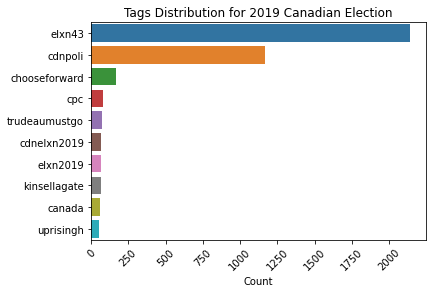

In [25]:
#plot the data frame in type of barplot
sns.barplot(x ='Count' , y =tag_df.index, data =tag_df)
plt.xticks(rotation=45)
plt.title('Tags Distribution for 2019 Canadian Election')

From the plot above, it can be seen that most of the tags are about the election of 43rd Parliament of Canada and political leanings of tweets. Let's apply this process to Sentiment Analysis dataset.

In [26]:
#apply the finding tag function to our sentiment_analysis data
sentiment_analysis['tags'] = sentiment_analysis['text'].apply(lambda row: find_tags(row))

In [27]:
#get rid of those empty list
list1 = sentiment_analysis['tags'].tolist()
list2 = [x for x in list1 if x]
output_list = []
for sublist in list2:
    for item in sublist:
        output_list.append(item)

In [28]:
#save all the tags that are used into an array
tag_arr2 = pd.Series(output_list)
#create a data frame for the tag array
tag_df2 = pd.DataFrame({'Count':tag_arr2.value_counts().head(10)})
tag_df2

,Count
trecru,14189
nationaldogday,2270
tbworld2016,1225
pushawardskathniels,1062
quote,1061
love,972
pjnet,903
travel,868
job,838
win,773


Text(0.5, 1.0, 'Tags Distribution for Sentiment Analysis')

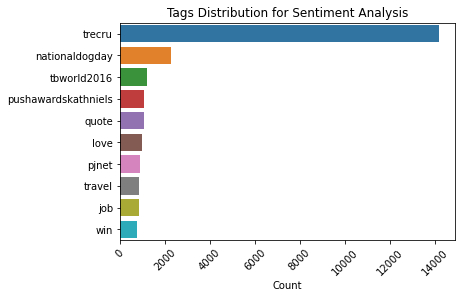

In [29]:
#plot the data frame in type of barplot
sns.barplot(x ='Count' , y =tag_df2.index, data =tag_df2)
plt.xticks(rotation=45)
plt.title('Tags Distribution for Sentiment Analysis')

Next step is to design a simple procedure that determines the political party (Liberal, Conservatives or New Democratic Party (NDC)) of a given tweet and apply this procedure to all the tweets in the Canadian Elections dataset. The first thing need to do is to find some key words that could distinguish tweets into different parties.

In [30]:
#from websites, some key words can be chosen to determine the political party
party_dict = {'liberal' :['trudeau', "justin", "justintrudeau","libs", "liberal","liberals","red","teamtrudeau","lpc"], 
'Conservative':["andrew","scheer","andrewscheer", "conservative","blue", "conservatives","cpc","hq"],
'NDP':["ndp","orange","quebec","jagmeet","singh","jagmeetsingh","ptndp","ndpoli","democratic"],
'Other' : ["bq","gpc","green","bloc"]}

In [31]:
def party_det(text):
    #try to match those text words with those key words
    result = []
    #match with liberal key words
    for word in party_dict['liberal']:
        if word in text.split(' '):
            result.append("Liberal")
    #match with Conservative key words  
    for word in party_dict['Conservative']:
        if word in text.split(' '):
            result.append("Conservative")
    #match with NDP key words 
    for word in party_dict['NDP']:
        if word in text.split(' '):
            result.append("NDP")
    #match with Other key words
    for word in party_dict['Other']:
        if word in text.split(' '):
            result.append("Other")
    if len(result) > 0:
        return max(set(result),key = result.count)
    elif len(result) ==0:
        return 'Other'

In [32]:
#create a new column for those political party prediction
ca_2019['Political Party Prediction']= ca_2019['clean_text'].apply(lambda row: party_det(row))

Text(0.5, 1.0, 'Political Party Distribution')

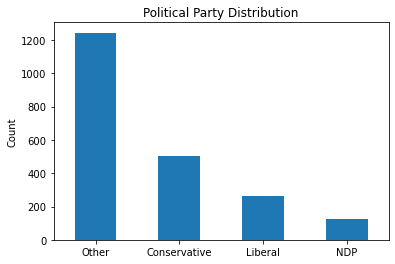

In [33]:
#use barplot to show the distribution of political parties
ca_2019['Political Party Prediction'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title('Political Party Distribution')

From the plot above, it can be seen that most of the tweets are distinguished as Other party. This is mainly because we used a simple method to divide our data. If we collect more distinguishing words, our result might be better. However, the 3 major competitive parties have relatively close number of tweets.

Another interesting insight of this classified data is that we could investigate how many positive and negative tweets in Liberal class.

Text(0.5, 1.0, 'Sentiment Distribution in Liberal related tweets')

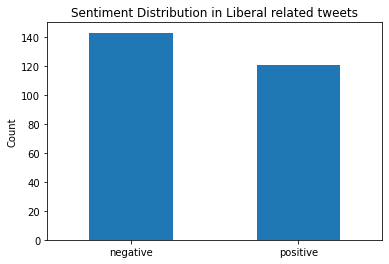

In [34]:
#filtering down the dataset by using Liberal Class
ca_2019[ca_2019['Political Party Prediction'] == "Liberal"]['sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title('Sentiment Distribution in Liberal related tweets')

Based on the plot, it can be found that the number of negative tweets are more than positive tweets. Let's investigate the reason behind those negative tweets.

Text(0.5, 1.0, 'Negative Reason Distribution for Liberal')

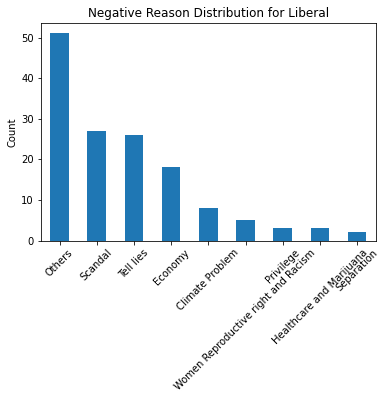

In [35]:
#filtering down the dataset by using Liberal Class
temp = ca_2019[ca_2019['Political Party Prediction'] == "Liberal"]
#find the reason shown in the native_reason column
temp[temp['sentiment']=='negative']['negative_reason'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title('Negative Reason Distribution for Liberal')

While some negative reasons are unknown, the plot above shows that most of tweet users in the dataset think Liberal party is affected by political scandal and lies. Furthermore, some of people also think that Liberal party should take the blame on the economy and environment problems.

Let's investigate more on Conservative party.

Text(0.5, 1.0, 'Sentiment Distribution in Liberal related tweets')

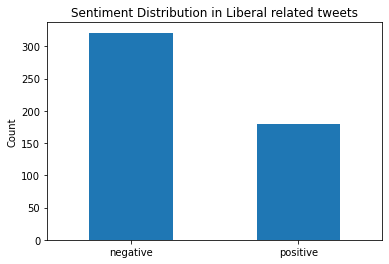

In [36]:
#filtering down the dataset by using Conservative Class
ca_2019[ca_2019['Political Party Prediction'] == "Conservative"]['sentiment'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title('Sentiment Distribution in Liberal related tweets')

Text(0.5, 1.0, 'Negative Reason Distribution for Liberal')

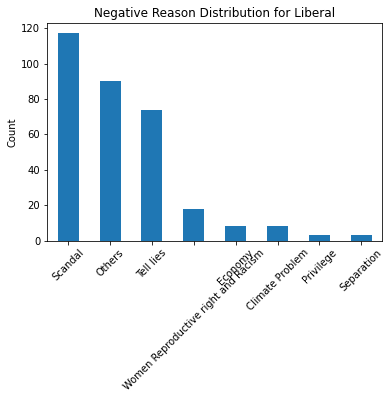

In [37]:
#filtering down the dataset by using Conservative Class
temp = ca_2019[ca_2019['Political Party Prediction'] == "Conservative"]
#find the reason shown in the native_reason column
temp[temp['sentiment']=='negative']['negative_reason'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title('Negative Reason Distribution for Liberal')

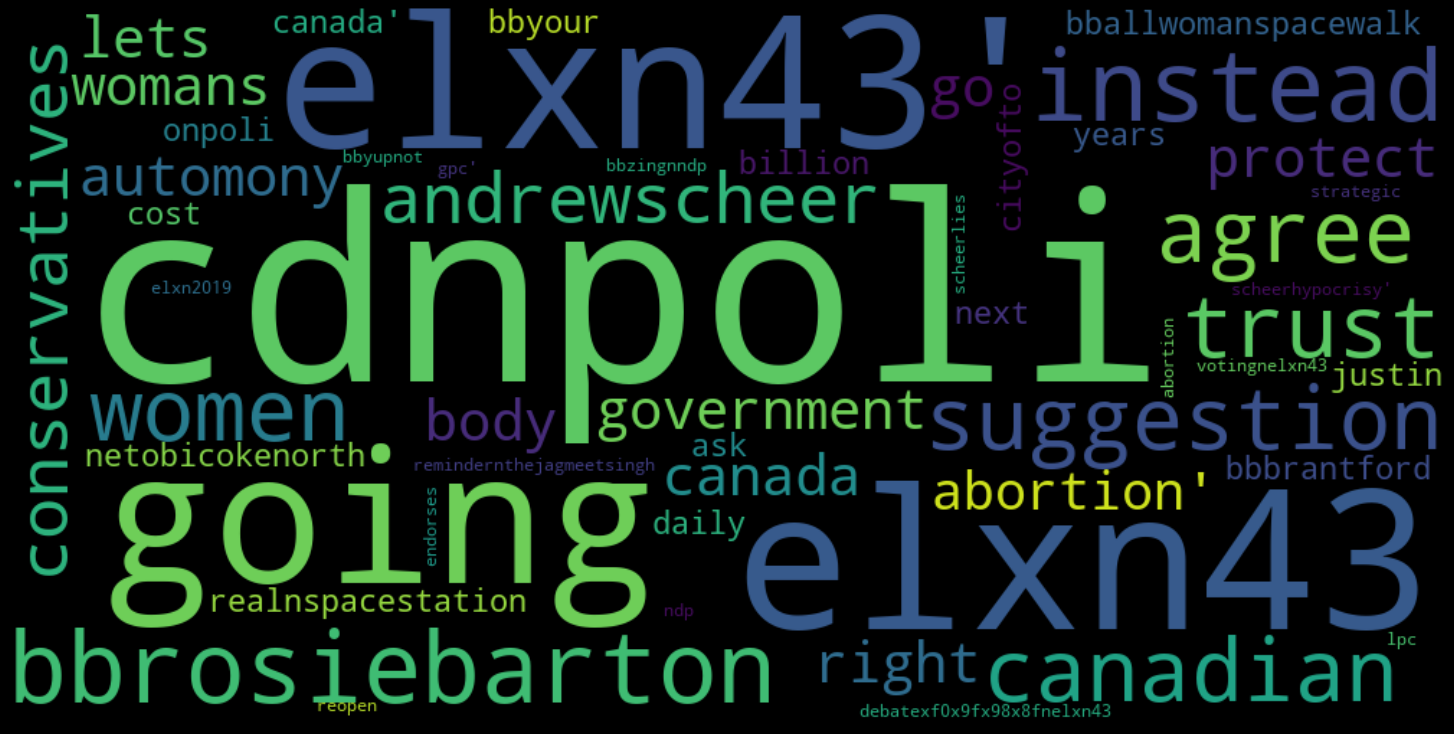

In [38]:
from wordcloud import WordCloud
#transfer the clean text column in to a list of string
word_ca_2019 = ca_2019['clean_text'].values
#create a word cloud
wordcloud = WordCloud(width = 1000,height = 500,background_color = 'black').generate(str(word_ca_2019))
fig = plt.figure(figsize = (20, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Step 3: Model Preparation

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
#obtain our dataset
data = sentiment_analysis[['clean_text','label']]

In [81]:
#obtain text and target array
X = data.iloc[:,[0]].values.flatten()
y = data.iloc[:,1].values.flatten().astype('int')

After obtaining our dataset, let's extract word frequency and calculate TF-IDF for our text value.

#### Word Frequency(WF)

In [82]:
#vetorize our dataset
wf_vec = CountVectorizer(max_features = 1000)
X_wfvec = wf_vec.fit_transform(X.ravel()).toarray()

In [83]:
#split the dataset
X_train_wf, X_test_wf , y_train_wf, y_test_wf = train_test_split(X_wfvec , y , test_size = 0.3, random_state = 0 )

Let's print first 100 features.

In [49]:
# print first 50 features
print(wf_vec.get_feature_names()[:100])

['10', '100', '11', '12', '15', '16', '1st', '20', '2016', '2017', '25', '30', '50', 'absolutely', 'abuse', 'account', 'action', 'actually', 'ad', 'adorable', 'af', 'afternoon', 'ago', 'ahead', 'aint', 'album', 'almost', 'alone', 'already', 'also', 'always', 'amazing', 'america', 'american', 'angel', 'animals', 'anniversary', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'app', 'apple', 'appreciate', 'appreciated', 'arent', 'around', 'art', 'artist', 'ask', 'ass', 'attack', 'available', 'award', 'away', 'awesome', 'b10', 'b5', 'ba', 'babe', 'babies', 'baby', 'back', 'bad', 'bag', 'ball', 'bamazing', 'ban', 'band', 'banother', 'bare', 'bawesome', 'bbe', 'bbeautiful', 'bbest', 'bc', 'bcan', 'bcant', 'bcheck', 'bcome', 'bcongrats', 'bcongratulations', 'bday', 'bdo', 'bdont', 'beach', 'beat', 'beautiful', 'beauty', 'become', 'bed', 'behind', 'believe', 'benjoy', 'best', 'bet', 'better', 'bfor', 'bfound']


#### TF-IDF

In [50]:
#vetorize our dataset
tfidf_vec = TfidfVectorizer(max_features = 1000)
X_tfidfvec = tfidf_vec.fit_transform(X.ravel()).toarray()

In [51]:
#split the dataset
X_train_tfidf, X_test_tfidf , y_train_tfidf , y_test_tfidf = train_test_split(X_tfidfvec , y , test_size = 0.3, random_state = 0 )

In [52]:
# print first 50 features
print(tfidf_vec.get_feature_names()[:100])

['10', '100', '11', '12', '15', '16', '1st', '20', '2016', '2017', '25', '30', '50', 'absolutely', 'abuse', 'account', 'action', 'actually', 'ad', 'adorable', 'af', 'afternoon', 'ago', 'ahead', 'aint', 'album', 'almost', 'alone', 'already', 'also', 'always', 'amazing', 'america', 'american', 'angel', 'animals', 'anniversary', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'app', 'apple', 'appreciate', 'appreciated', 'arent', 'around', 'art', 'artist', 'ask', 'ass', 'attack', 'available', 'award', 'away', 'awesome', 'b10', 'b5', 'ba', 'babe', 'babies', 'baby', 'back', 'bad', 'bag', 'ball', 'bamazing', 'ban', 'band', 'banother', 'bare', 'bawesome', 'bbe', 'bbeautiful', 'bbest', 'bc', 'bcan', 'bcant', 'bcheck', 'bcome', 'bcongrats', 'bcongratulations', 'bday', 'bdo', 'bdont', 'beach', 'beat', 'beautiful', 'beauty', 'become', 'bed', 'behind', 'believe', 'benjoy', 'best', 'bet', 'better', 'bfor', 'bfound']


So far our dataset is ready for model implementation.

# Step 4: Model implementation and tuning
Try the following seven classification algorithms:
- Logistic regression
- K-NN
- Naive Bayes
- SVM
- Decision trees
- Random Forest
- XGBoost 

#### 1) Logistic regression
##### for WF

In [73]:
import warnings
warnings.filterwarnings("ignore")

In [74]:
#model setup and training
model = LogisticRegression()
params = {"C":[0.5,0.8,0.9,1,5]}

#use GridSearchCV to tune the parameter
clf = GridSearchCV(model, params, scoring = "f1",cv=5) 
clf.fit(X_train_wf,y_train_wf)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 0.8, 0.9, 1, 5]}, scoring='f1')

In [75]:
#tuned parameter
print("Best C value for the LR model using WF data")
print(clf.best_params_)

Best C value for the LR model using WF data
{'C': 5}


              precision    recall  f1-score   support

           0       0.86      0.92      0.89     53707
           1       0.96      0.93      0.94    111411

    accuracy                           0.93    165118
   macro avg       0.91      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



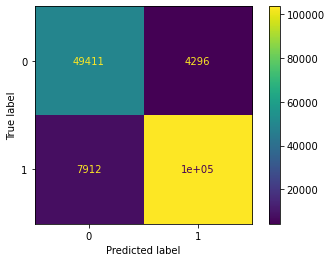

In [76]:
#prediction
y_predict = clf.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

##### for TF_IDF

In [205]:
#model setup and training
model = LogisticRegression()
params = {"C":[0.5,0.8,0.9,1,5]}

#use GridSearchCV to tune the parameter
clf2 = GridSearchCV(model, params, scoring = "f1",cv=5) 
clf2.fit(X_train_tfidf,y_train_tfidf)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 0.8, 0.9, 1, 5]}, scoring='f1')

In [206]:
#tuned parameter
print("Best C value for the LR model TF_IDF data")
print(clf2.best_params_)

Best C value for the LR model TF_IDF data
{'C': 5}


              precision    recall  f1-score   support

           0       0.87      0.91      0.89     53707
           1       0.96      0.93      0.94    111411

    accuracy                           0.93    165118
   macro avg       0.91      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



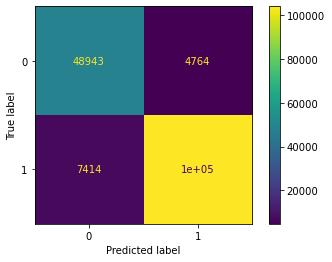

In [207]:
#prediction
y_predict = clf2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 2) KNN

##### for WF

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     53707
           1       0.94      0.90      0.92    111411

    accuracy                           0.89    165118
   macro avg       0.87      0.89      0.88    165118
weighted avg       0.90      0.89      0.89    165118



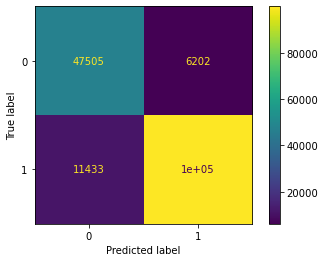

In [211]:
#train knn model for WF data
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train_wf,y_train_wf)
y_predict = clf_knn.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

#### for TF_IDF

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     53707
           1       0.93      0.87      0.89    111411

    accuracy                           0.86    165118
   macro avg       0.84      0.86      0.85    165118
weighted avg       0.87      0.86      0.86    165118



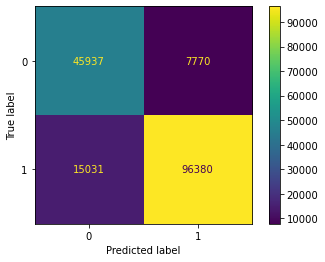

In [212]:
#train knn model for TF_IDF data
clf_knn2 = KNeighborsClassifier(n_neighbors=3)
clf_knn2.fit(X_train_tfidf,y_train_tfidf)
y_predict = clf_knn2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 3) Naive Bayes

###### for WF

              precision    recall  f1-score   support

           0       0.64      0.95      0.76     53707
           1       0.97      0.74      0.84    111411

    accuracy                           0.81    165118
   macro avg       0.80      0.84      0.80    165118
weighted avg       0.86      0.81      0.81    165118



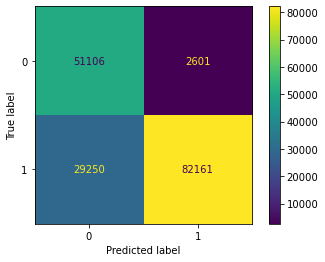

In [215]:
#train Gasussian NB model for WF data
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_wf,y_train_wf)
y_predict = clf_gnb.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

###### for TF_IDF

              precision    recall  f1-score   support

           0       0.66      0.94      0.77     53707
           1       0.97      0.76      0.85    111411

    accuracy                           0.82    165118
   macro avg       0.81      0.85      0.81    165118
weighted avg       0.86      0.82      0.83    165118



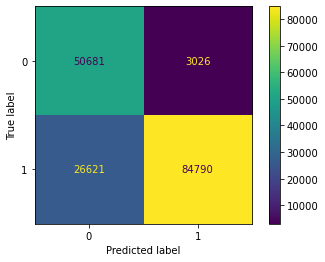

In [216]:
#train Gasussian NB model for TF_IDF data
clf_gnb2 = GaussianNB()
clf_gnb2.fit(X_train_tfidf,y_train_tfidf)
y_predict = clf_gnb2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 4) SVM

###### for WF

C:\Users\Henry\.conda\envs\test\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.89      0.00      0.01     53707
           1       0.68      1.00      0.81    111411

    accuracy                           0.68    165118
   macro avg       0.78      0.50      0.41    165118
weighted avg       0.75      0.68      0.55    165118



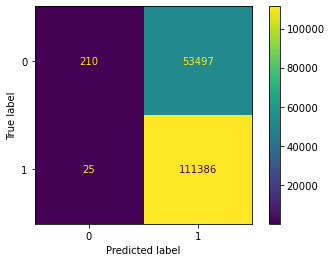

In [53]:
#train SVM model for WF data
clf_svm = svm.SVC(max_iter=100)
clf_svm.fit(X_train_wf,y_train_wf)
y_predict = clf_svm.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

###### for TF_IDF

C:\Users\Henry\.conda\envs\test\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.66      0.10      0.18     53707
           1       0.69      0.97      0.81    111411

    accuracy                           0.69    165118
   macro avg       0.68      0.54      0.49    165118
weighted avg       0.68      0.69      0.60    165118



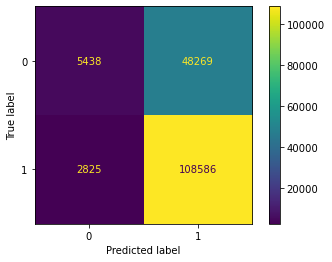

In [54]:
#train SVM model for TF_IDF data
clf_svm2 = svm.SVC(max_iter=100)
clf_svm2.fit(X_train_tfidf,y_train_tfidf)
y_predict = clf_svm2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 5) Decision Trees

##### for WF

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     53707
           1       0.95      0.93      0.94    111411

    accuracy                           0.92    165118
   macro avg       0.90      0.91      0.91    165118
weighted avg       0.92      0.92      0.92    165118



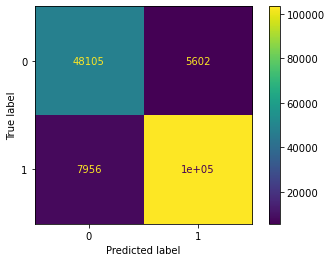

In [55]:
#train Decision Tree model for WF data
clf_dt = DecisionTreeClassifier(criterion='entropy')
clf_dt.fit(X_train_wf,y_train_wf)
y_predict = clf_dt.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

##### for TF_IDF

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     53707
           1       0.95      0.93      0.94    111411

    accuracy                           0.92    165118
   macro avg       0.90      0.91      0.91    165118
weighted avg       0.92      0.92      0.92    165118



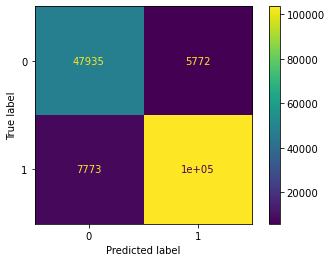

In [56]:
#train Decision Tree model for TF_IDF data
clf_dt2 = DecisionTreeClassifier(criterion='entropy')
clf_dt2.fit(X_train_tfidf,y_train_tfidf)
y_predict = clf_dt2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 6) Random Forest

##### for WF

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     53707
           1       0.95      0.94      0.95    111411

    accuracy                           0.93    165118
   macro avg       0.91      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



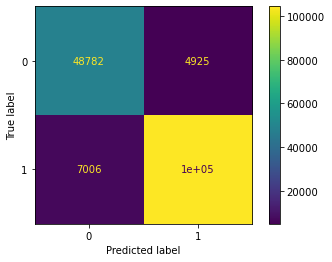

In [57]:
#train Random Forest model for WF data
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_wf,y_train_wf)
y_predict = clf_rf.predict(X_test_wf)
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

##### for TF_IDF

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     53707
           1       0.96      0.94      0.95    111411

    accuracy                           0.93    165118
   macro avg       0.92      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



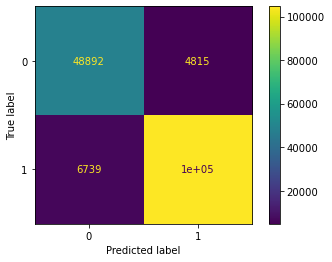

In [58]:
#train Random Forest model for TF_IDF data
clf_rf2 = RandomForestClassifier()
clf_rf2.fit(X_train_tfidf,y_train_tfidf)
y_predict = clf_rf2.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

#### 7) XGBOOST

###### WF

In [67]:
#train XGboost model for WF data
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
datatrain = xgboost.DMatrix(X_train_wf,label = y_train_wf)
bst = xgboost.train(param, datatrain, num_round)
datatest = xgboost.DMatrix(X_test_wf,label = y_test_wf)
y_predict = bst.predict(datatest)

              precision    recall  f1-score   support

           0       0.91      0.14      0.24     53707
           1       0.71      0.99      0.83    111411

    accuracy                           0.72    165118
   macro avg       0.81      0.57      0.53    165118
weighted avg       0.77      0.72      0.64    165118



Exception ignored in: <function Booster.__del__ at 0x000002DA4051EC18>
Traceback (most recent call last):
  File "C:\Users\Henry\.conda\envs\test\lib\site-packages\xgboost\core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


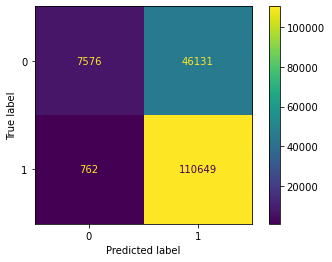

In [68]:
#modify y_predict
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
         y_predict[i]=1
    else:
        y_predict[i]=0  
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

##### TF_IDF

              precision    recall  f1-score   support

           0       0.91      0.14      0.24     53707
           1       0.71      0.99      0.83    111411

    accuracy                           0.72    165118
   macro avg       0.81      0.57      0.54    165118
weighted avg       0.77      0.72      0.64    165118



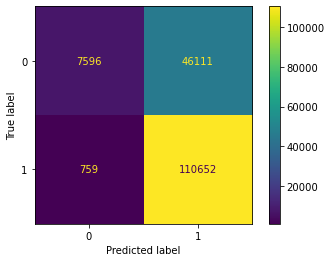

In [70]:
#train XGboost model for WF data
datatrain = xgboost.DMatrix(X_train_tfidf,label = y_train_tfidf)
datatest = xgboost.DMatrix(X_test_tfidf,label = y_test_tfidf)
bst2 = xgboost.train( param, datatrain, num_round)
y_predict = bst2.predict(datatest)
#modify y_predict
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
         y_predict[i]=1
    else:
        y_predict[i]=0  
print(classification_report(y_test_tfidf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_tfidf, y_predict)).plot()

Based on the performance report shown above, both of Logistic Regression and Random Forest achieve 93% of accuracy on prediction.  However, Logistic Regression model have a higher f1 score on capturing negative sentiments. Therefore, Logistic Regression is chosen as the best model in this process. While  the WF and TFIDF data process did not affect too much on the predicting result, the WF is chosen for the data preocess. Let's apply the model to our canadian election data to predict the sentiment.

##### Logistic Regression Model

In [77]:
###step 1: Modify the sentiment label###
def labelfunc(x):
    if x == 'positive':
        return 1
    elif x== "negative":
        return 0
ca_2019['label'] = ca_2019['sentiment'].apply(lambda row: labelfunc(row))

In [78]:
#obtain our dataset
data_ca = ca_2019[['clean_text','label']]
X_ca = data_ca.iloc[:,0].values.flatten()
y_ca = data_ca.iloc[:,1].values.flatten().astype('int')

In [89]:
#vetorize our dataset in WF
X_ca_wfvec = wf_vec.transform(X_ca.ravel()).toarray()

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      1006
           1       0.67      0.47      0.55      1127

    accuracy                           0.60      2133
   macro avg       0.61      0.61      0.59      2133
weighted avg       0.62      0.60      0.59      2133



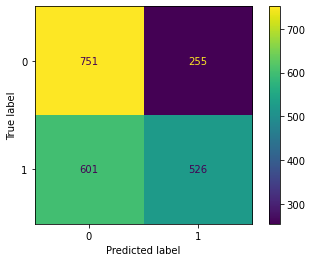

In [90]:
#prediction
y_predict = clf.predict(X_ca_wfvec)
print(classification_report(y_ca, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_ca, y_predict)).plot()

In [92]:
#save the prediction
ca_2019['predict_lable'] = y_predict
ca_2019.head()

,sentiment,negative_reason,text,clean_text,tags,Political Party Prediction,label,predict_lable
0,negative,Women Reproductive right and Racism,"b""@rosiebarton so instead of your suggestion, ...",bbrosiebarton instead suggestion agree canadia...,"[canadian, women, andrewscheer, conservatives,...",Conservative,0,0
1,positive,NaN,"b""#allwomanspacewalk it's real!\n@space_statio...",bballwomanspacewalk realnspacestation netobico...,"[allwomanspacewalk, etobicokenorth, cityofto, ...",Other,1,0
2,negative,Economy,"b""#brantford it's going to cost you $94 billio...",bbbrantford going cost 94 billion next 4 years...,"[brantford, elxn43, cdnpoli, canada]",Liberal,0,1
3,positive,NaN,"b""#canada #canadaelection2019 #canadavotes \n#...",bbcanada canadaelection2019 canadavotes nelxn4...,"[canada, canadaelection2019, canadavotes, elxn43]",Other,1,0
4,negative,Economy,"b""#canada #taxpayers are sick &amp; tired of h...",bbcanada taxpayers sick tired hard earned dona...,"[canada, taxpayers, trudeaumustgo, canada, snc...",Other,0,0


<AxesSubplot:xlabel='Political Party Prediction', ylabel='count'>

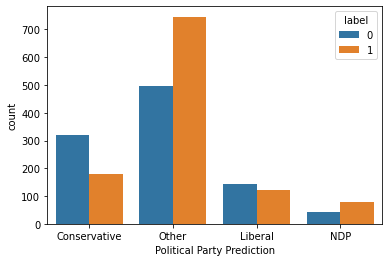

In [93]:
sns.countplot(x='Political Party Prediction',hue='label',data=ca_2019)
plt.title('True Sentiment Distribution')

Text(0.5, 1.0, 'Predict Sentiment Distribution')

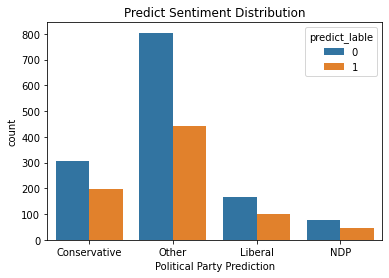

In [96]:
sns.countplot(x='Political Party Prediction',hue='predict_lable',data=ca_2019)
plt.title('Predict Sentiment Distribution')

After applying logistic regression model to canadian 2019 election dataset, we can see that the model did not perform well. With the Word Frequency vectorization, the logistic regression model only reach 60 percent of the accuracy. Furthermore, the biggest difference occurred in the class of "Other". While the most of users have positive sentiment to the "Other" party, the model predict that users have more negative thoughts on that party. One major reason would be that tweeter users usually have specific words to describe their negative thoughts, but these specific words were not captured clearly by the sentiment analysis model, while the words used and vectorized in the model were all from sentiment analysis dataset. This problem would lead to a bad performance. 

On the other hand, the model correctly predict the relationship among the people's opinion on the 2019 election. For example, the model correctly predict that most people support or show the positive opinion to 'Conservative', while 'Liberal' and 'NDP' have less supporters. In terms of the nagative sentiment, the model also captures that the number of people who does not support 'Conservative' occupy the largest portion.


### Negative Reason Analysis

In [104]:
#select those negative rows
ca_2019_negative = ca_2019[ca_2019['label']==0]
#get the reason array
reason_list = ca_2019_negative['negative_reason'].unique().tolist()

In [106]:
#define a function for labeling the reason
def reason_label(x):
    return reason_list.index(x)

In [107]:
#create a new column for reason label
ca_2019_negative['reason_label'] = ca_2019_negative['negative_reason'].apply(lambda row: reason_label(row))

In [108]:
#obtain our dataset
data_ca = ca_2019_negative[['clean_text','reason_label']]
X_ca = data_ca.iloc[:,0].values.flatten()
y_ca = data_ca.iloc[:,1].values.flatten().astype('int')

In [109]:
#vetorize our dataset
wf_vec = CountVectorizer(max_features = 1000)
X_wfvec = wf_vec.fit_transform(X_ca.ravel()).toarray()

In [111]:
#split the dataset
X_train_wf, X_test_wf , y_train_wf , y_test_wf = train_test_split(X_wfvec , y_ca , test_size = 0.3, random_state = 0 )

So far the dataset is prepared for the multiclassification model.

###### Logistic Regression

In [116]:
#model setup and training
model = LogisticRegression()
params = {"C":[0.5,0.8,0.9,1,5]}

#use GridSearchCV to tune the parameter
clf = GridSearchCV(model, params, scoring = "f1",cv=5) 
clf.fit(X_train_wf,y_train_wf)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 0.8, 0.9, 1, 5]}, scoring='f1')

Logistic Regression
              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.57      0.21      0.31        19
           2       0.50      0.73      0.60       115
           3       0.56      0.43      0.49        92
           4       0.47      0.44      0.46        54
           5       0.00      0.00      0.00         1
           6       1.00      0.20      0.33        10
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1

    accuracy                           0.51       302
   macro avg       0.37      0.24      0.26       302
weighted avg       0.52      0.51      0.49       302



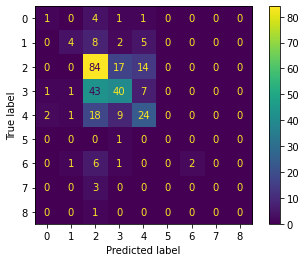

In [117]:
#prediction
y_predict = clf.predict(X_test_wf)
print('Logistic Regression')
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

##### Random Forest

Random Forest
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.64      0.37      0.47        19
           2       0.54      0.81      0.65       115
           3       0.70      0.47      0.56        92
           4       0.52      0.44      0.48        54
           5       0.00      0.00      0.00         1
           6       1.00      0.40      0.57        10
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1

    accuracy                           0.58       302
   macro avg       0.44      0.34      0.37       302
weighted avg       0.60      0.58      0.56       302



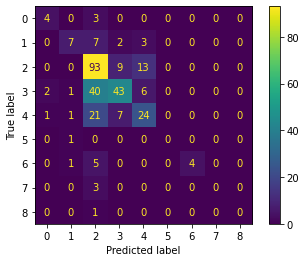

In [120]:
#train Random Forest model for WF data
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_wf,y_train_wf)
y_predict = clf_rf.predict(X_test_wf)
print('Random Forest')
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

In [122]:
predict_arr = pd.Series(y_predict).apply(lambda i: reason_list[i])
reason_arr = pd.Series(y_test_wf).apply(lambda i: reason_list[i])

###### KNN

KNN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        19
           2       0.39      0.97      0.56       115
           3       0.83      0.05      0.10        92
           4       0.00      0.00      0.00        54
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1

    accuracy                           0.39       302
   macro avg       0.14      0.11      0.07       302
weighted avg       0.40      0.39      0.24       302



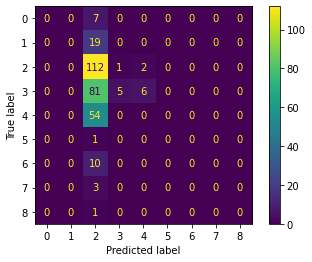

In [119]:
#train knn model for WF data
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train_wf,y_train_wf)
y_predict = clf_knn.predict(X_test_wf)
print('KNN')
print(classification_report(y_test_wf, y_predict))
ConfusionMatrixDisplay(confusion_matrix(y_test_wf, y_predict)).plot()

From the result above, it is clear that the best model among these 3 algorithm is Random Forest which achieve 58% of accuracy. Let's investigate the difference between the predicted reason and true reason.

Text(0.5, 1.0, 'Predict Negative Reason Distribution')

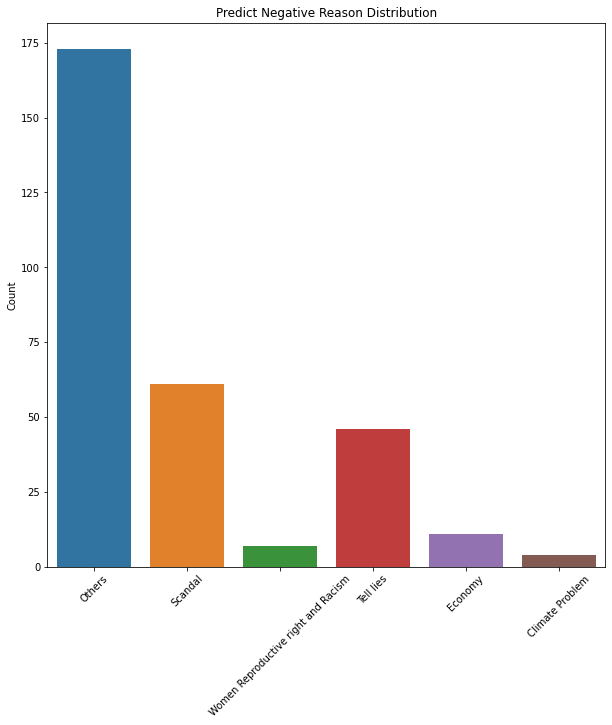

In [130]:
plt.figure(figsize=(10, 10))
sns.countplot(predict_arr)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title('Predict Negative Reason Distribution')

Text(0.5, 1.0, 'True Negative Reason Distribution')

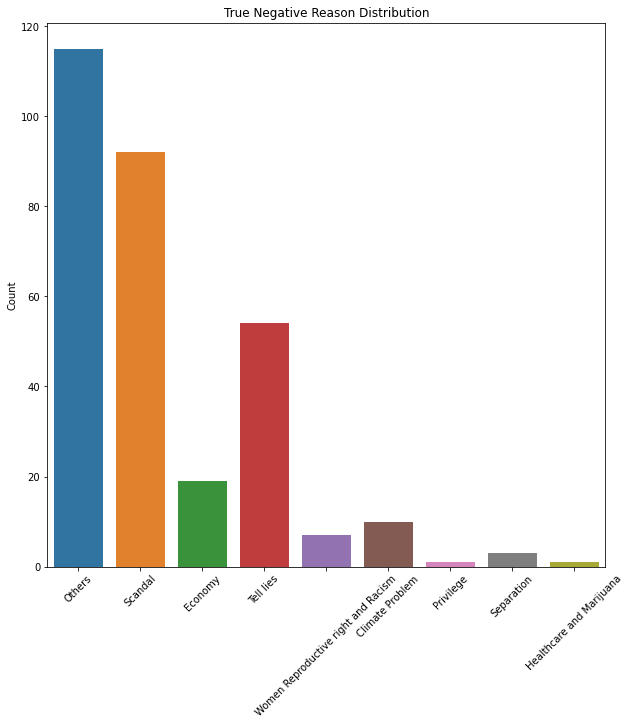

In [131]:
plt.figure(figsize=(10, 10))
sns.countplot(reason_arr)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title('True Negative Reason Distribution')

One reason that cause this bad performance is that the dataset is imbalanced and the "Other" reason occupied a large portion of the entire dataset. The model would be trained as a high accuracy by simply predicting all the reason as "Other", but this would result the model to have a low precision and recall score. Secondly, the number of entire dataset is limited.

Although the model did not predict the number of each reason accurately, it describe the reason distribution well. Others, Scandal and Telling Lies are top 3 reasons that people have negative sentiments.

# Step 5: Discussion

After using the first NLP sentiment analysis model, we can see that the model did not perform well on predicting the sentiments of users on 2019 Elections topic, while the performance of the model on the sentiment analysis dataset is pretty good. However, the model did summarize that tweeter users have more negative sentiments on a specifc political party especially for "Conservative" and "Liberal", which are the biggest 2 competitive political parties in Canada.

Secondly, a random forest model was applied to predict the negative reason regarding the 2019 elections. Although the model did not predict the number of each reason accurately, it describe the reason distribution well. Others, Scandal and Telling Lies are top 3 reasons that people have negative sentiments.

##### Improvement Suggestion:
For the first model, the model performance can be imporved by adding more Canadian Election related tweets to the sentiment analysis dataset. In this case, more election related words can be added into bag of words for analysis. Therefore, the accuracy of the model when predicting the sentiments of users can be increased.

For the second model, one optional method to increase the performance is to increase the training data. Since we only have 2133 rows of tweets, the prediction on each negative reason would be difficult. After adding the data, the variation of each word in the bag can be increased, In this case, the model would perform better.